# IMPORT MODULES

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy  import integrate
import astropy.units as u
import glob
from scipy.optimize import minimize
from gammapy.stats.fit_statistics import wstat, cash
import matplotlib


plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

## Import some Gammapy function:
- Observation
- Spectral models
### This code was based on gammapy v0.19

In [30]:
from gammapy.data import Observation, Observations
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    PowerLawSpectralModel,
    SpectralModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    TemplateSpectralModel
)

import os
print(os.getenv("GAMMAPY_DATA"))
os.environ["GAMMAPY_DATA"] = "/fefs/aswg/workspace/mathilde.croisonnier/Omega_Centauri/gammapy-datasets/1.0/"


/fefs/aswg/workspace/mathilde.croisonnier/Omega_Centauri/gammapy-datasets/1.0/


# Custom functions

### get_IRF_factors

In [31]:
def get_IRF_factors(observation, ereco, etrue,offset, mask_migra):
    """
    Calculates the factors of the instrument response function (IRF) for a given observation.

    Parameters:
    observation (object): Gammapy Observation object.
    ereco (array): Array of reconstructed energy values.
    etrue (array): Array of true energy values.
    mask_migra (array): Boolean mask for energy migration.

    Returns:
    array: IRF factors array.
    """

    # Get the 2D energy dispersion and normalize it
    edisp2D = observation.edisp
    edisp2D.normalize()

    # Calculate the edisp matrix
    ereco = ereco[:, None]
    edisp = edisp2D.evaluate(offset=offset, energy_true=etrue, migra=ereco/etrue) / etrue
    edisp      = edisp * mask_migra
    
    aeff       = observation.aeff.evaluate( energy_true=etrue[None,:])
    aeff       = aeff * mask_migra
    
    IRF        = aeff  * edisp 

    return IRF

### integrate_over_each_range

In [32]:
# this function is used for performing the numerical integration over  E' of G(E,E')
def integrate_over_each_range(integrand, bins, Delta):
    """
    Integrate a given integrand over specified ranges.

    This function performs numerical integration of a provided integrand array over
    each sub-interval defined by `Delta` within the `bins`. Integration is carried
    out using Simpson's rule.

    Parameters:
    integrand (np.ndarray): The values to be integrated. Assumed to be a 3D array,
                            with the integration performed along the second axis.
    bins (np.ndarray): The x-values corresponding to the integrand. These are the
                       points at which the integrand has been evaluated.
    Delta (np.ndarray): The edges of the sub-intervals over which to integrate.
                        Must be sorted in ascending order.

    Returns:
    np.ndarray: An array of integrated values for each sub-interval defined in `Delta`.

    Example:
    >>> integrand = np.random.rand(10, 100, 5)  # For example purposes
    >>> bins = np.linspace(0, 10, 100)  # x-values where integrand is evaluated
    >>> Delta = np.array([1, 3, 5, 7])  # Edges of sub-intervals
    >>> integrate_over_each_range(integrand, bins, Delta)
    array([...])  # Returns an array of integrated values
    """
    
    # axis = 1, when integrating E_prime in the first step
    axis = 1
    # Find the indices in bins that match the edges in Delta
    indices = np.searchsorted(bins, Delta)
    
    # Initialize an array to store the results of the integration over each range
    integrals = []

    # Iterate over the ranges defined by Delta
    for i in range(len(Delta)-1):
        # Define the start and end index for the current range
        start_idx = indices[i]
        end_idx = indices[i+1]
        
        # Extract the integrand values and corresponding bins for the current range
        y_values = integrand[:, start_idx:end_idx, :]
        x_values = bins[start_idx:end_idx]
        
        # Compute the integral for the current range using Simpson's rule
        integral = integrate.simpson(y_values, x=x_values, axis=axis)
        integrals.append(integral)

    return np.array(integrals)





### step_function_integral

In [33]:
# this function is needed for performing the integeral over time and get the "time migration" matrix
def step_function_integral(a, b, a_prime, b_prime):
    """
    Calculate the integral of a step function over specified intervals.

    This function computes the integral of a step function that is 1 within the
    intervals defined by vectors a and b, and 0 otherwise, over another set of
    intervals defined by a_prime and b_prime. The function handles vectorized inputs
    and computes the overlap of each pair of intervals from the two sets.

    Parameters:
    a (np.ndarray): A 1D array of start points of the intervals where the step function is 1.
    b (np.ndarray): A 1D array of end points of the intervals where the step function is 1.
                    Must be the same shape as a.
    a_prime (np.ndarray): A 2D array of start points of the intervals over which to integrate.
    b_prime (np.ndarray): A 2D array of end points of the intervals over which to integrate.
                          Must be the same shape as a_prime.

    Returns:
    np.ndarray: A 3D array of the integral of the step function over each interval defined by
                a_prime and b_prime. The shape of the output array is based on the broadcasting
                rules applied to the input shapes.

    Example:
    >>> a = np.array([0, 5])
    >>> b = np.array([3, 10])
    >>> a_prime = np.array([[1, 6], [4, 8]])
    >>> b_prime = np.array([[2, 7], [5, 9]])
    >>> step_function_integral(a, b, a_prime, b_prime)
    array([[[ 1,  1],
            [ 0,  2]],

           [[ 2,  3],
            [ 1,  2]]])
    """
    
    # Ensure inputs are numpy arrays for vectorized operations
    a = np.asarray(a)
    b = np.asarray(b)
    a_prime = np.asarray(a_prime)
    b_prime = np.asarray(b_prime)
    
    # Calculate the overlap between [a, b] and [a_prime, b_prime] using broadcasting
    overlap_start = np.maximum(a[None,None,:], a_prime[:,:,None])
    overlap_end = np.minimum(b[None,None,:], b_prime[:,:,None])

    # The result is the positive length of the overlap, or 0 where there is no overlap
    overlap_length = np.maximum(0, overlap_end - overlap_start)

    return overlap_length


# Class

### TimeDelay_Binned_Likelihood 

In [34]:
#This is the only custom Class needed for the analysis

class TimeDelay_Binned_Likelihood:
    """
    This class is designed to handle the calculation of a binned signal for Lorentz Invariance Violation (LIV) studies.
    
    It includes methods for setting up the energy and time bins, computing the instrument response function (IRF),
    performing the minimization of a log-likelihood function, and calculating the expected counts based on a
    spectral model modified by an EBL model.
    
    Parameters:
    -----------
    E_prime : astropy.units.Quantity
        Reconstructed (observed) energy bins.
    t : astropy.units.Quantity
        True (intrinsic) time bins.
    t_prime : astropy.units.Quantity
        Observed (measured) time bins.
    spectral_model : callable
        Spectral model function.
    EBL_model : callable
        Extragalactic Background Light (EBL) model function.
    all_observations : list
        List containing observation data, including IRF information.
    n_on : array-like, optional
        Number of on-source counts (signal + background).
    n_off : array-like, optional
        Number of off-source counts (background only).
    alpha : array-like, optional
        Ratio of exposure times for on-source and off-source observations.
        
    Attributes:
    -----------
    energy_unit : astropy.units.Quantity
        Energy unit (GeV).
    time_unit : astropy.units.Quantity
        Time unit (seconds).
    length_unit : astropy.units.Quantity
        Length unit (cm).
    IRF_unit : astropy.units.Quantity
        Instrument response function unit.
    phi_unit : astropy.units.Quantity
        Flux unit.

    Methods:
    --------
    update_eta(eta):
        Update the parameter eta and compute delta_t_ik.
    minimize_loglkl(guess, bounds):
        Minimize the log likelihood function.
    compute_loglkl(SED_pars):
        Compute the log likelihood using the expected counts.
    compute_expected_counts(SED_pars):
        Compute the expected counts.
    step_function_flux(SED_pars):
        Compute the flux using the spectral model.
    get_IRF():
        Compute the instrument response function.
    get_E_bins_and_migra():
        Compute the energy bins and migra values.
    """
    
    def __init__(self, E_prime, t, t_prime, spectral_model, EBL_model, all_observations, n_on=None, n_off=None, alpha=None):
        """Initialize class variables and compute initial binning."""
        
        # Observed data: IRF and counts
        self.n_on, self.n_off, self.alpha = n_on, n_off, alpha  
        self.all_observations             = all_observations   
        
        # Model: flux and EBL
        self.spectral_model = spectral_model
        self.EBL_model      = EBL_model
        
        # Define units
        self.energy_unit = u.GeV
        self.time_unit   = u.s
        self.length_unit = u.cm
        self.IRF_unit    = self.length_unit**2 / self.energy_unit 
        self.phi_unit    = (self.time_unit * self.length_unit**2 * self.energy_unit)**(-1)
        
        # Convert the provided energies and times to the defined units
        self.E_prime_J     = E_prime.to(self.energy_unit).value
        self.t             = t.to(self.time_unit).value
        self.t_prime       = t_prime.to(self.time_unit).value
        
        # Define left and right edges of observed and true time bins
        self.t_prime_left  = self.t_prime[:-1]
        self.t_prime_right = self.t_prime[1:]
        self.t_left        = self.t_prime[:-1]
        self.t_right       = self.t_prime[1:]
        
        # Refine energy bins for numerical integration (geometric binning)
        self.refinement_factor_geom_binning    = 20  # Refinement factor for bins used for numerical integration, so that in each bin we have 20 more bins that can be used for the integration
        self.number_of_E_prime_bins = len(self.E_prime_J) - 1
        self.E_prime_j                    = np.geomspace(self.E_prime_J[0], self.E_prime_J[-1],
                                         self.number_of_E_prime_bins * self.refinement_factor_geom_binning + 1)
        
        # Define the mid-points of the bins for the actual calculation
        self.E_prime_j_mid = np.sqrt(self.E_prime_j[:-1] * self.E_prime_j[1:])
        
        # Obtain the binning in true E using the IRF in observations
        self.get_E_j_and_migra()
        
        # Integrate IRF over each energy bin
        self.get_IRF()  #self.IRF_grid has shape (E, E',t')
        self.G_j_Iprime_Jprime = integrate_over_each_range(self.IRF_grid, self.E_prime_j_mid, self.E_prime_J)  # G has shape (E', E,t')
        
    def update_eta(self,eta):
        """
        Update the parameter eta.

        Parameters:
        -----------
        eta : astropy.units.Quantity
            The parameter eta in units of (time unit / energy unit).
        """
        self.eta                             = eta.to( self.time_unit/self.energy_unit).value
        
        # Compute the matrix \Delta t_{ik} (E, eta)
        self.Delta_I_Iprime_j = step_function_integral( self.t_prime_left, self.t_prime_right,
                       self.t_left[None,:] + self.eta*self.E_j_mid[:,None],
                       self.t_right[None,:] + self.eta*self.E_j_mid[:,None],
                           )        # shape: E, t, t'

        
        self.G_Delta_j_I_Iprime_Jprime = self.G_j_Iprime_Jprime[:,:,None,:] * self.Delta_I_Iprime_j[None,:,:,:]   # shape: E',E, t, t'
        
    
    def minimize_loglkl(self,guess, bounds):
        """
        Minimize the log likelihood function.

        Parameters:
        -----------
        guess : ndarray
            Initial guess for the parameters.
        bounds : list of tuples
            Bounds for parameter values.

        Returns:
        --------
        None
        """
        self.solution = minimize(self.compute_loglkl, guess, bounds= bounds , method='L-BFGS-B',
                   options={'maxfun': 1000000,  'gtol': 1e-8}) 
        if self.solution.success:
            self.loglkl_min = self.solution.fun
            print("Minimum value for -2 log(Lkl) :", self.loglkl_min)
        else:
            print("Optimization failed:", self.solution.message)

        
    
    
    def compute_loglkl(self,SED_pars):
        """
        Compute the log likelihood using the expected counts.

        Parameters:
        -----------
        SED_pars : ndarray
            Parameters for the spectral energy distribution.

        Returns:
        --------
        loglkl : float
            The value of the log likelihood.
        """
        self.compute_expected_counts( SED_pars )
        return np.sum( wstat(n_on = self.n_on, n_off=self.n_off, 
                             alpha= self.alpha, 
                             mu_sig=self.expected_signal) )
    
    def compute_expected_counts(self, SED_pars):
        """
        Compute the expected counts.

        Parameters:
        -----------
        SED_pars : ndarray
            Parameters for the spectral energy distribution.

        Returns:
        --------
        None
        """
        # shape: E',E, t, t'
        self.Phi_j_I        = self.step_function_flux(SED_pars)  
        self.sum_over_I      = np.sum( self.Phi_j_I[None,:,:,None]*self.G_Delta_j_I_Iprime_Jprime, axis=2) 
        self.expected_signal = integrate.simpson(self.sum_over_I , x=self.E_j_mid, axis=1)
         
    def step_function_flux(self, SED_pars):
        """
        Compute the flux using the spectral model.

        Parameters:
        -----------
        SED_pars : ndarray
            Parameters for the spectral energy distribution.

        Returns:
        --------
        flux : ndarray
            Flux values in phi_unit.
        """
        
        if len(SED_pars) == len(self.t_left):
            # this mean that the user is only letting the amplitude to vary
            A_k     = SED_pars
            _alpha   = 2.1267e+00 
            beta     = 1.1481e-01  
        else:
            # this mean that the user is also letting the alpha and beta to vary
            A_k     = SED_pars[:-2]
            _alpha  = SED_pars[-2]
            beta    = SED_pars[-1]
        E0      = 202.82 *u.GeV   #2.0200e+02   
        ampl    = 7.0885e-09 / (u.cm**2 *u.s * u.TeV)
        SED     = self.spectral_model( amplitude=ampl , reference=E0, alpha=_alpha, beta=beta)
        SED_EBL = SED * self.EBL_model
        flux    =  A_k[None,:]* SED_EBL(self.E_j_mid*self.energy_unit)[:,None]
        return     flux.to(self.phi_unit).value
        
    def get_IRF(self,):
        """
        Compute the instrument response function.

        Returns:
        --------
        None
        """
        IRF  = np.array( [get_IRF_factors(
                            observation = obs, 
                            ereco       = self.E_prime_j_mid*self.energy_unit, 
                            etrue       = self.E_j_mid*self.energy_unit, 
                            offset      = 0.4*u.deg,
                            mask_migra  = self.mask_migra ).to( self.IRF_unit ).value 
                          
                            for obs in self.all_observations]) 
        # FOR NOW WE ASSUME IRF CONSTANT IN TIME
        self.IRF_grid = IRF.mean(axis=0).T[:,:,None] #self.IRF_grid has shape (E, E',t')
        
    def get_E_j_and_migra(self,):
        """
        Compute the energy bins and migra values.

        Returns:
        --------
        None
        """
        number_points_true_energy = 200
        # Get migra min and max values
        all_migra       = np.array([obs.edisp.axes['migra'].bounds.value for obs in self.all_observations])
        migra_min       = np.min(all_migra[:, 0])
        migra_max       = np.max(all_migra[:, 1])
        # Define the bin edges and  mid-points for E 
        self.E_j        = np.geomspace(self.E_prime_j[0] / migra_max, self.E_prime_j[-1] / migra_min,number_points_true_energy )
        self.E_j_mid    = np.sqrt(self.E_j[:-1] * self.E_j[1:])
        # Compute  mask_migra
        etrue_min       = self.E_prime_j_mid[:, None] / migra_max
        etrue_max       = self.E_prime_j_mid[:, None] / migra_min
        self.mask_migra = (self.E_j_mid[None, :] >= etrue_min) * (self.E_j_mid[None, :] <= etrue_max)
        
        
        

        

# Analysis

## Import observation

In [14]:
all_obs = []
#for run in sorted(glob.glob("../../lst-school/DL3/Mrk421/dl3_LST-1.Run*.fits.gz")):
for run in sorted(glob.glob( "./DL3_files/20*fits")):
    print(run)
    obs = Observation.read(run)
    all_obs.append(obs)

./DL3_files/20140426_05034767_DL3_Mrk421-W0.40+090.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034768_DL3_Mrk421-W0.40+270.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034771_DL3_Mrk421-W0.40+270.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034772_DL3_Mrk421-W0.40+000.fits
./DL3_files/20140426_05034773_DL3_Mrk421-W0.40+180.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034774_DL3_Mrk421-W0.40+090.fits
./DL3_files/20140426_05034775_DL3_Mrk421-W0.40+270.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034776_DL3_Mrk421-W0.40+000.fits
./DL3_files/20140426_05034777_DL3_Mrk421-W0.40+180.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


### all_obs
#add reconstructed binning and store observation in gammapy, where you can extract on and off counts 

## Get counts (I have already computed those and saved in a npy array)

In [15]:
n_on  = np.load("results/ON_counts.npy")
n_off = np.load("results/OFF_counts.npy") 

alpha = 1
print(n_off.size, n_on.size,alpha)

610 610 1


## Define binning in reco energy and time 
## (bins must the same used for getting the ON and OFF counts)

In [16]:
# This binning in unifor: only bins ghave same size
# In principle one can try different bins, indeed in the paper we studied how the resul change by using different binning|
t_prime_left  = np.array([0, 118.25297, 236.50594, 354.7589, 473.01187, 591.26484, 709.51781, 827.77078, 946.02374, 1064.2767, 
          1182.5297, 1300.7826, 1419.0356, 1537.2886, 1655.5416, 1773.7945, 1892.0475, 2010.3005, 2128.5534, 
          2246.8064, 2365.0594, 2483.3123, 2601.5653, 2719.8183, 2838.0712, 2956.3242, 3074.5772, 3192.8301, 
          3311.0831, 3429.3361, 3547.589, 3665.842, 3784.095, 3902.3479, 4020.6009, 4138.8539, 4257.1068, 
          4375.3598, 4493.6128, 4611.8657, 4730.1187, 4848.3717, 4966.6247, 5084.8776, 5203.1306, 5321.3836, 
          5439.6365, 5557.8895, 5676.1425, 5794.3954, 5912.6484, 6030.9014, 6149.1543, 6267.4073, 6385.6603, 
          6503.9132, 6622.1662, 6740.4192, 6858.6721, 6976.9251, 7095.1781, 7213.431, 7331.684, 7449.937, 7568.1899, 
          7686.4429, 7804.6959, 7922.9489, 8041.2018])*u.s

t_prime_right = np.array( [ 118.25297, 236.50594, 354.7589, 473.01187, 591.26484, 709.51781, 827.77078, 946.02374, 1064.2767,
                       1182.5297, 1300.7826, 1419.0356, 1537.2886, 1655.5416, 1773.7945, 1892.0475, 2010.3005, 2128.5534,
                       2246.8064, 2365.0594, 2483.3123, 2601.5653, 2719.8183, 2838.0712, 2956.3242, 3074.5772, 3192.8301,
                       3311.0831, 3429.3361, 3547.589, 3665.842, 3784.095, 3902.3479, 4020.6009, 4138.8539, 4257.1068, 
                       4375.3598, 4493.6128, 4611.8657, 4730.1187, 4848.3717, 4966.6247, 5084.8776, 5203.1306, 5321.3836,
                       5439.6365, 5557.8895, 5676.1425, 5794.3954, 5912.6484, 6030.9014, 6149.1543, 6267.4073, 6385.6603,
                       6503.9132, 6622.1662, 6740.4192, 6858.6721, 6976.9251, 7095.1781, 7213.431, 7331.684, 7449.937, 
                       7568.1899, 7686.4429, 7804.6959, 7922.9489, 8041.2018, 8159.4548])*u.s

#t_prime = np.append( t_prime_left, t_prime_right[-1] ) 
#t_prime = np.linspace(0*u.s, 2600*u.s, 16 )  
t_prime = np.linspace(0.37215709686435616*u.s,  8136.806521177289*u.s, 62) 

# Binning in observed and intrinsic time is the same (but can be different in principle)
#t = np.linspace(0*u.s, 2600*u.s, 16 ) 
t = t_prime       
    
# Binning in time
E_prime = np.geomspace(  30*u.GeV, 10*u.TeV, 11)

# Run minimization over $F_I$ for different $\eta$

In [17]:
z           = 0.03
dominguez   = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=z)

#E_prime_min  = 100*u.GeV,     E_prime_max   = 10*u.TeV,        number_of_bins_in_E_prime=11,

LIV_class = TimeDelay_Binned_Likelihood(
            
            #BINNING
            E_prime = E_prime,
            t       = t,     
            t_prime = t_prime,
    
            # Spectral model
            spectral_model   = LogParabolaSpectralModel,
            EBL_model        = dominguez,

            # IRF
            all_observations = all_obs,
    
            # OBSERVED COUNTS
            n_on = n_on.T, #################################### add .T when my data 
            n_off = n_off.T,################################### same
            alpha = alpha   
)

In [18]:
%%time

F_I_guess    = np.ones_like(LIV_class.t_left)
N        = len(F_I_guess)
bounds   = [(1e-100,None) for kk in range(N)]



all_guess = []
all_loglkl_min = []
all_eta        =  np.linspace(-60,1000,3)*u.s/u.TeV  #np.linspace(-50,50,15)*u.s/u.TeV + 0*u.s/u.TeV
for eta in all_eta :
    LIV_class.update_eta(eta)
    LIV_class.minimize_loglkl( guess=F_I_guess, bounds=bounds)
    loglkl_min = LIV_class.loglkl_min
    all_loglkl_min.append( loglkl_min )
    all_guess.append( LIV_class.solution.x)

Minimum value for -2 log(Lkl) : 842.7784446286389
Minimum value for -2 log(Lkl) : 931.3315549235074
Minimum value for -2 log(Lkl) : 1122.5301499952534
CPU times: user 2min 6s, sys: 1min 11s, total: 3min 18s
Wall time: 3min 19s


# Plot $-2 \Delta \log \mathcal{L} $

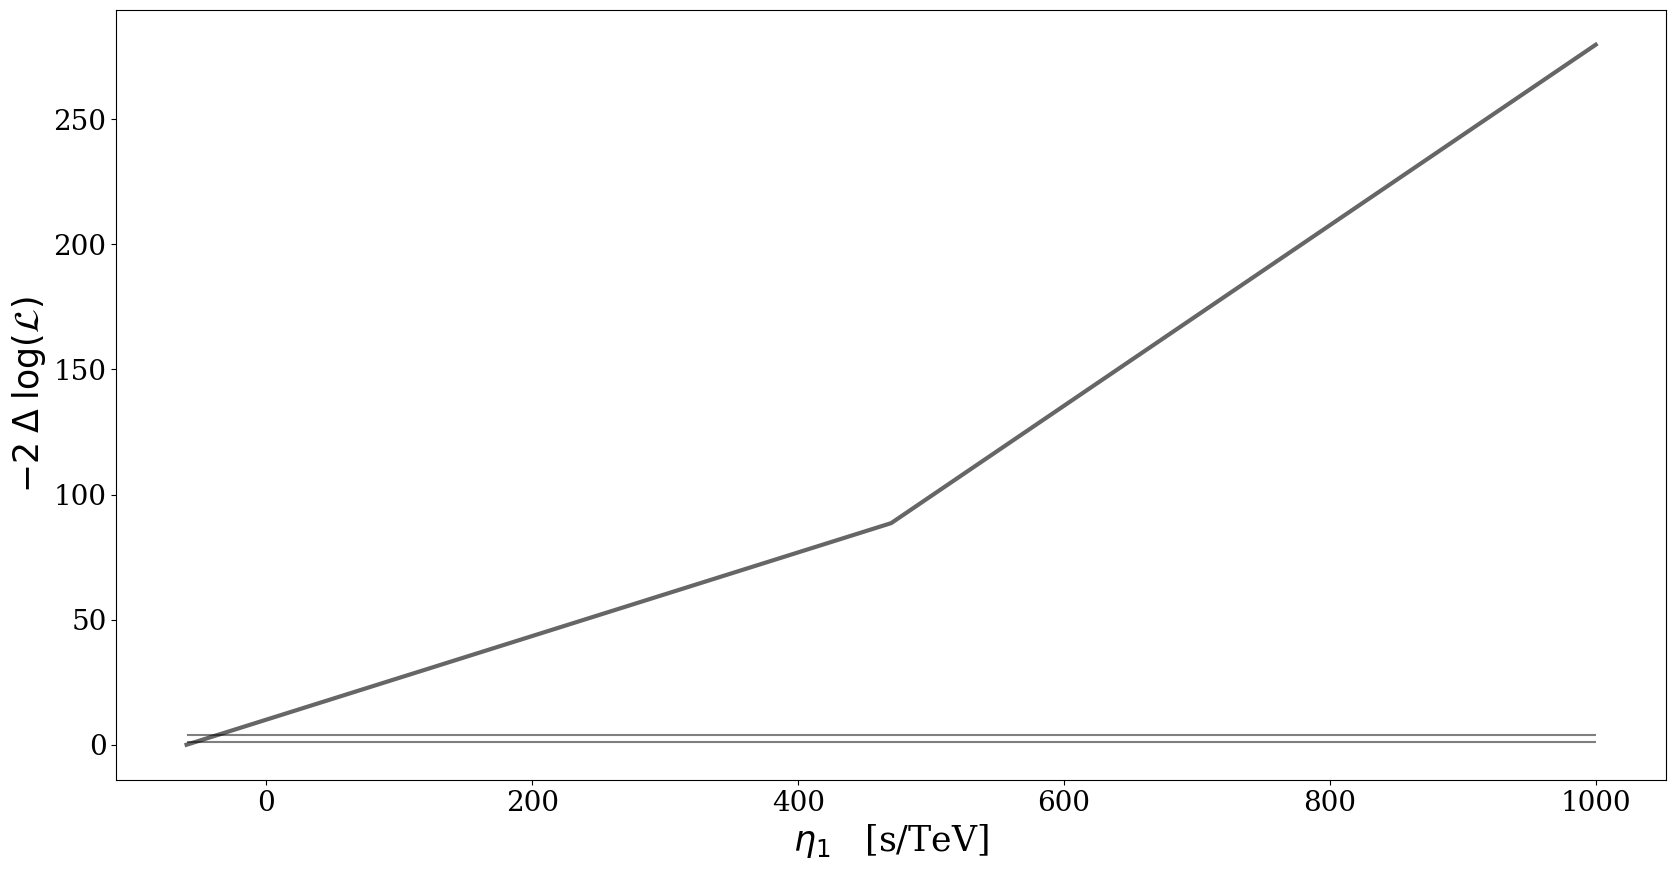

In [19]:
matplotlib.rcParams['text.usetex'] = False

fig, ax = plt.subplots( 1,1,figsize=(20,10))

ax.set_xlabel(r'$\eta_1$   [s/TeV]')
ax.set_ylabel(r'$ -2\;  \Delta \; \log( \mathcal{L} ) $')


plt.plot(all_eta,all_loglkl_min- np.min(all_loglkl_min), c='k', linewidth=3 , alpha=0.6)
#plt.plot(all_eta,np.abs(all_loglkl_min- np.max(all_loglkl_min)), c='k', linewidth=3 , alpha=0.6)

plt.hlines( [1,3.8], xmin= all_eta.min().value, xmax=all_eta.max().value,color='k', alpha =0.5)


# Plot $F_I$ on top of the observed excess in time

<ErrorbarContainer object of 3 artists>

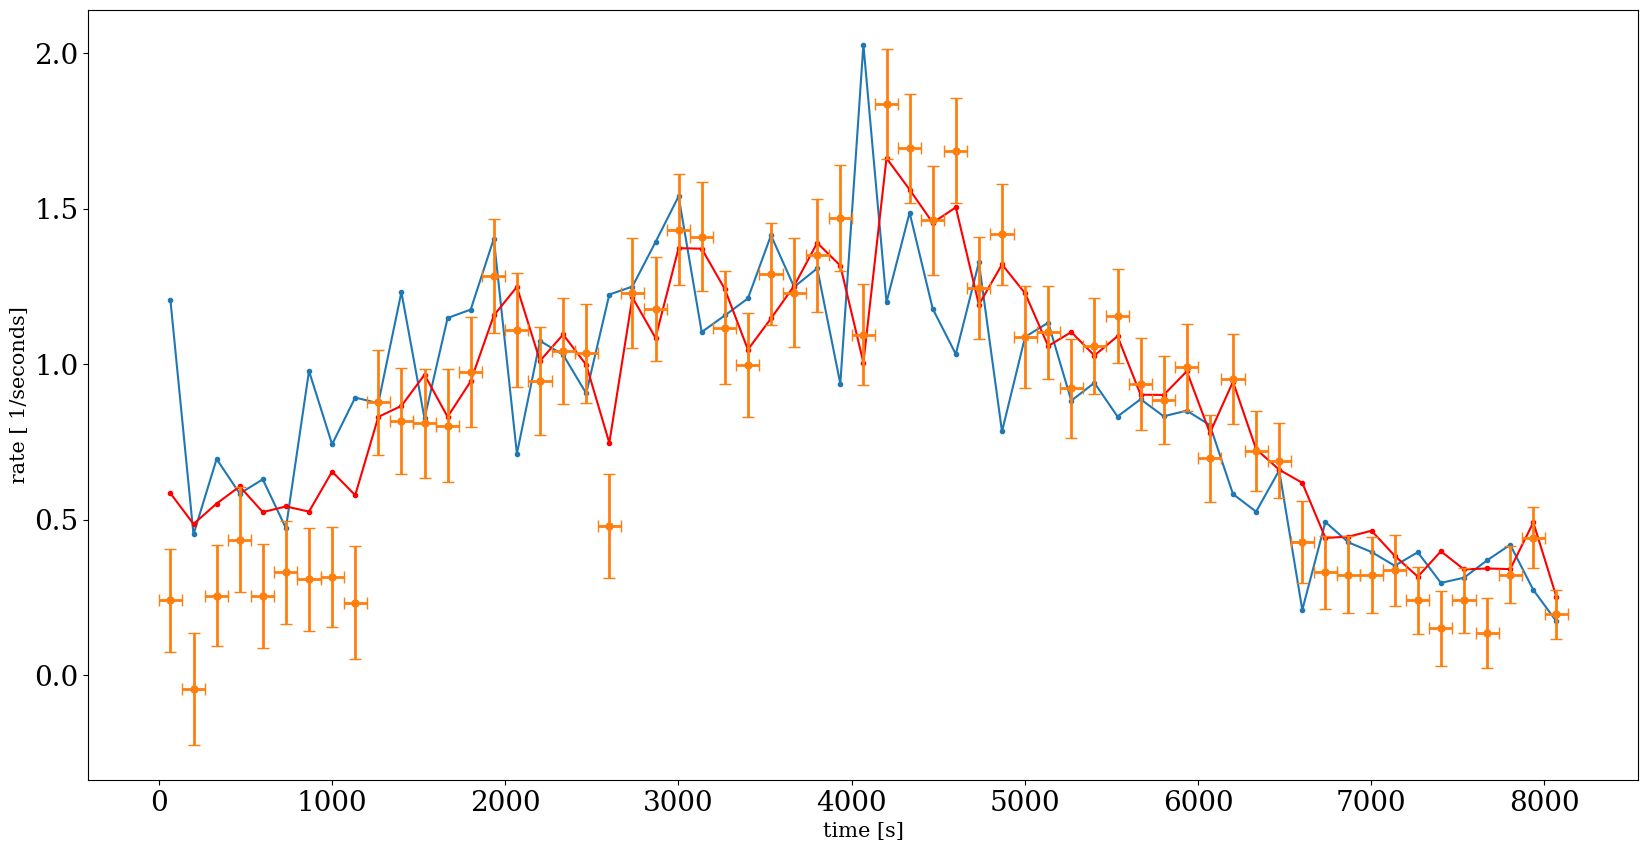

In [22]:

binwidth       = t[1:]-t[:-1]
bincenters     = (t[1:]+t[:-1])/2

LC_intr        = (n_on.T.sum(axis=0) - n_off.T.sum(axis=0)*2)/binwidth 
LC_intr_unc    = np.sqrt( (n_on.T.sum(axis=0) + n_off.T.sum(axis=0)*2**2) )/binwidth 
#LC_intr        = (n_on.sum(axis=0) - n_off.sum(axis=0))/binwidth 
#LC_intr_unc    = np.sqrt( (n_on.sum(axis=0) + n_off.sum(axis=0)) ) /binwidth

fig , ax = plt.subplots(figsize=(20,10))

x = all_guess[-1]
plt.plot(bincenters.value,x, marker='.')

x = all_guess[0]
plt.plot(bincenters.value,x, marker='.', color = "red")

ax.set_ylabel(r' rate [ 1/seconds] ',size=15)
ax.set_xlabel('time [s]',size=15)
ax.errorbar(bincenters.value, LC_intr, LC_intr_unc ,binwidth.value/2,fmt='o', elinewidth=2, markersize=5, capsize=4)

In [67]:
# NERONOV DELAY 

#eta est notre retard, il faut l'ecrire en fonction de z, B. Changer aussi la dependance en E-5/2 

from scipy.integrate import quad
from scipy.integrate import cumtrapz, quad
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

# Cosmological constant and parameters 
H0 = 71 * u.km / u.s / u.Mpc
Omega_M = 0.27
Omega_A = 0.73
c = 299792.458 * u.km/u.s 
a0 = 1 

# Parameters 
E_y0 = 0.01 * u.TeV 
z_E = 0.14

In [68]:
# Compute t_yy 

def dt_dz(z): #eq3
    return 1.0 / (H0 * (1 + z) * np.sqrt(Omega_M * (1 + z)**3 + Omega_A)) 

def D_y(z): #eq19
    return ((40)*( 1/ ( 1+z)**2 ) * ( E_y0 /( 20 *u.TeV)) **-1 )*u.Mpc
    
def integrand(z):
    return dt_dz(z).to(u.s).value / D_y(z).to(u.Mpc).value 
    
def eq21(z_yy): #eq21
    result, _ = quad(integrand, z_yy, z_E) #reverse integration for redshift 
    return result  - 1

sol = root_scalar(eq21, bracket=[0, z_E - 1e-14], method='brentq')
z_yy = sol.root

print("redshift of emission :", z_E) 
print( "redshift of interaction of the primary gamma : ", z_yy)  

redshift of emission : 0.14
redshift of interaction of the primary gamma :  0.13999999999999002


same z_yy and z_E, can't say why

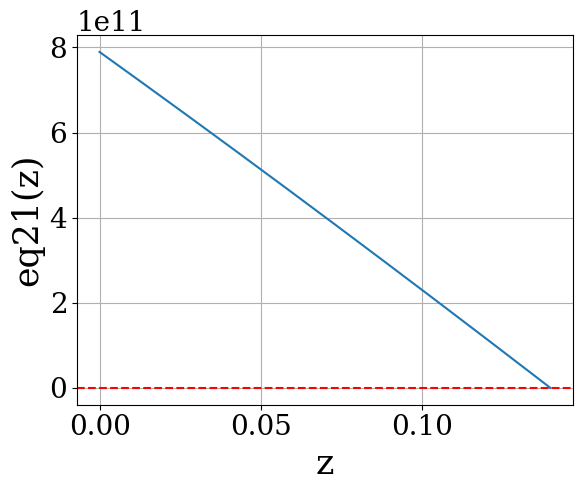

In [69]:
matplotlib.rcParams['text.usetex'] = False
zs = np.linspace(0, z_E, 500)
ys = [eq21(z) for z in zs]

plt.plot(zs, ys)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("z")
plt.ylabel("eq21(z)")
plt.grid(True)
plt.show()

In [70]:
#Compute t_E 
t_E, _ = quad(lambda z: dt_dz(z).to(u.s).value, 0, z_E) #eq37
t_E = t_E * u.s

#Conversion z_yy in t_yy 
t_yy, _ = quad(lambda z: dt_dz(z).to(u.s).value, z_yy, z_E) 
t_yy = t_yy * u.s

#______________________
print("emission  time : ", t_E)
print("travel time of primary gamma : " , t_yy)

emission  time :  5.531607675880628e+16 s
travel time of primary gamma :  3583.4192216622773 s


In [74]:
#Compute t_cascade

#Parameters
def comoving_distance(zi,z): #eq32
    integrand = lambda z: 1.0 / np.sqrt(Omega_M * (1 + z)**3 + Omega_A)
    integral, _ = quad(integrand, zi, z)
    return (1 / (a0*H0)) * integral *c 
    
d_E = comoving_distance(0, z_E).to(u.Mpc).value
d_yy = comoving_distance(z_yy, z_E).to(u.Mpc).value #not sure if d_yy is the distance from z_E to z_yy or the distance from 0 to z_yy
print(d_E, d_yy) 

E_e = 0.5* E_y0
B0 = 1e-18*u.G


573.8455124969499 3.968922585312964e-11


In [75]:
#Defining 1/a(t) 
z_array = np.linspace(0, 10, 10000)
dt_dz_vals = np.array([dt_dz(z).to(u.s).value for z in z_array])  
t_array = cumtrapz(dt_dz_vals, z_array, initial=0)  
z_of_t = interp1d(t_array, z_array, kind='cubic', fill_value='extrapolate')

def a_t(t):
    z = z_of_t(t)
    return a0 / (1.0 + z)
    
def integrand(t):  
        return 1 / a_t(t)
    
def eq38(t_cascade):
    result, _ = quad(integrand, 0, t_cascade)*u.s
    return (result.value* c.to(u.Mpc/u.s).value - delta_r.to(u.Mpc).value)

d_y_val, _ = quad(integrand, t_E.value-t_yy.value, t_E.value)*u.s #eq 22 #Change of integration interval
d_y = (c.to(u.Mpc/u.s) * d_y_val).to(u.Mpc).value
print(d_y, d_yy) 

#Defining delta and theta 
delta = 3e-6*u.rad *(1+z_yy)**(-2)* (B0 / (1e-18*u.G))* (E_e / (10*u.TeV))**(-2) #eq 30
sin_theta = (d_y/d_E)*np.sin(delta.value) #eq 33 
theta = np.arcsin(sin_theta) 
angle = delta.value + theta
delta_r = np.sqrt(d_E**2 + d_yy**2 - 2 * d_E * d_yy * np.cos(angle)) *u.Mpc 
print(delta, theta, delta_r, d_E)

sol = root_scalar(eq38, bracket=[0, 1e20], method='brentq')

if sol.converged:
    t_cascade = sol.root * u.s
    print( t_cascade, t_E, t_yy) 
else:
    print("Fail")

t_delay = t_yy - ( t_E - t_cascade) 

print ("The delay is : ", t_delay ) 
############################
#we have assumed tau_0 > 1, delta <<1
#z_yy ~ z_E = z 
#z<<1 ( numerical limit ) 
#Eq ( 40 ), but we need the formula for z~1 too
#3.969565739254524e-11 3.968922585312964e-11
#0.0009233610341643746 rad 6.387332000541828e-17 573.8455124969103 Mpc 573.8455124969499
#5.531607745429314e+16 s 5.531607675880628e+16 s 3583.4192216622773 s
#The delay is :  695490439.4192216 s

3.969565739254524e-11 3.968922585312964e-11
9.233610341643747 rad 1.3143586594759385e-14 573.8455124969889 Mpc 573.8455124969499
5.531607745430024e+16 s 5.531607675880628e+16 s 3583.4192216622773 s
The delay is :  695497543.4192216 s


/tmp/ipykernel_26583/1968783440.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(integrand, 0, t_cascade)*u.s


/tmp/ipykernel_26583/1968783440.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(integrand, 0, t_cascade)*u.s


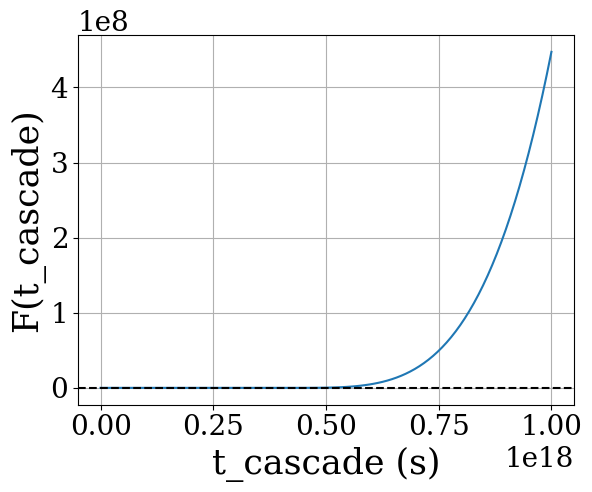

In [76]:
t_range = np.linspace(0, 1e18, 100)
f_vals = [eq38(tc) for tc in t_range]

plt.plot(t_range, f_vals)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("t_cascade (s)")
plt.ylabel("F(t_cascade)")
plt.yscale('linear')
plt.grid(True)
plt.show()


t_cascade always equal the same, whatever the z_E 

In [77]:
eta = 

SyntaxError: invalid syntax (2150521073.py, line 1)